# Day 1: Ordinary Least Squares (OLS) for Return Prediction

## 🎯 Learning Objectives
- Master OLS regression fundamentals
- Apply OLS to stock return prediction
- Understand assumptions and diagnostics
- Build trading signals from linear models

---

## 📚 Theory: OLS Regression

### The Model
$$y = X\beta + \epsilon$$

Where:
- $y$ = dependent variable (returns)
- $X$ = feature matrix
- $\beta$ = coefficients to estimate
- $\epsilon$ = error term

### OLS Estimator
$$\hat{\beta} = (X^TX)^{-1}X^Ty$$

### Key Assumptions (Gauss-Markov)
1. **Linearity**: $E[y|X] = X\beta$
2. **No Perfect Multicollinearity**: $X$ has full rank
3. **Exogeneity**: $E[\epsilon|X] = 0$
4. **Homoscedasticity**: $Var(\epsilon|X) = \sigma^2I$
5. **No Autocorrelation**: $Cov(\epsilon_i, \epsilon_j) = 0$ for $i \neq j$

### Pros & Cons for Finance

| Pros | Cons |
|------|------|
| Interpretable coefficients | Assumes linear relationships |
| Fast computation | Sensitive to outliers |
| Statistical inference | Heteroscedasticity in returns |
| BLUE (Best Linear Unbiased Estimator) | Autocorrelation issues |

---

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
from scipy import stats

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252
RISK_FREE_RATE = 0.05

# Download data
tickers = ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'GS', 'SPY']
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading stock data...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()

print(f"✅ Data: {len(returns)} days, {len(tickers)} assets")
print(f"📅 Period: {returns.index[0].strftime('%Y-%m-%d')} to {returns.index[-1].strftime('%Y-%m-%d')}")

📥 Downloading stock data...
✅ Data: 1253 days, 6 assets
📅 Period: 2021-01-26 to 2026-01-21


In [2]:
# Feature Engineering for Return Prediction
target_stock = 'AAPL'
df = pd.DataFrame(index=returns.index)

# Technical Features
df['momentum_5'] = prices[target_stock].pct_change(5)  # 5-day momentum
df['momentum_20'] = prices[target_stock].pct_change(20)  # 20-day momentum
df['volatility_20'] = returns[target_stock].rolling(20).std() * np.sqrt(TRADING_DAYS)
df['volume_ratio'] = data['Volume'][target_stock] / data['Volume'][target_stock].rolling(20).mean()

# Moving Average Features
df['ma_ratio_10'] = prices[target_stock] / prices[target_stock].rolling(10).mean() - 1
df['ma_ratio_50'] = prices[target_stock] / prices[target_stock].rolling(50).mean() - 1

# Market Features
df['spy_return'] = returns['SPY']
df['spy_momentum'] = prices['SPY'].pct_change(5)

# Target: Next day return
df['target'] = returns[target_stock].shift(-1)

# Clean data
df = df.dropna()
print(f"\n📊 Features created: {len(df.columns)-1}")
print(f"📈 Samples: {len(df)}")


📊 Features created: 8
📈 Samples: 1204


In [3]:
# Prepare data for OLS
feature_cols = [c for c in df.columns if c != 'target']
X = df[feature_cols]
y = df['target']

# Time-series split (no future data leakage)
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Train: {len(X_train)} samples")
print(f"Test: {len(X_test)} samples")

Train: 963 samples
Test: 241 samples


In [4]:
# OLS with statsmodels (full statistical output)
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

ols_model = sm.OLS(y_train, X_train_const).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.4713
Date:                Thu, 22 Jan 2026   Prob (F-statistic):              0.877
Time:                        16:50:05   Log-Likelihood:                 2584.5
No. Observations:                 963   AIC:                            -5151.
Df Residuals:                     954   BIC:                            -5107.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0032      0.002      1.262

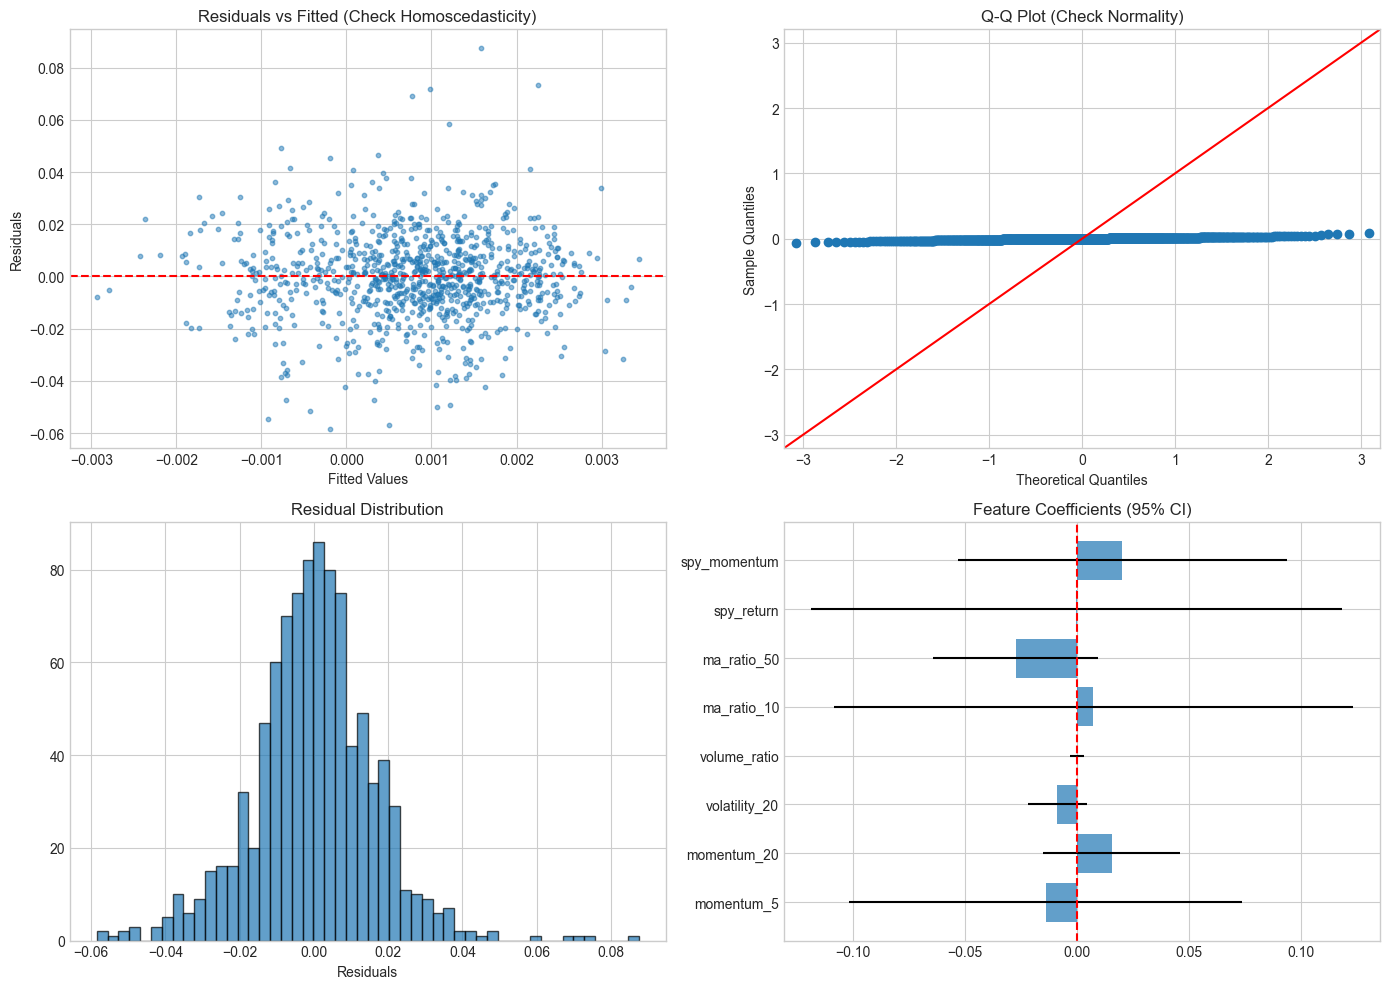

In [5]:
# Model Diagnostics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Residuals vs Fitted
fitted = ols_model.fittedvalues
residuals = ols_model.resid
axes[0, 0].scatter(fitted, residuals, alpha=0.5, s=10)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Fitted (Check Homoscedasticity)')

# 2. Q-Q Plot
sm.qqplot(residuals, line='45', ax=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot (Check Normality)')

# 3. Residuals Histogram
axes[1, 0].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_title('Residual Distribution')

# 4. Coefficient Plot
coefs = ols_model.params[1:]  # Exclude constant
errors = ols_model.bse[1:]
y_pos = np.arange(len(coefs))
axes[1, 1].barh(y_pos, coefs, xerr=1.96*errors, alpha=0.7)
axes[1, 1].set_yticks(y_pos)
axes[1, 1].set_yticklabels(coefs.index)
axes[1, 1].axvline(x=0, color='r', linestyle='--')
axes[1, 1].set_title('Feature Coefficients (95% CI)')

plt.tight_layout()
plt.show()

In [6]:
# Test Set Performance
y_pred = ols_model.predict(X_test_const)

print("\n" + "="*60)
print("OLS MODEL TEST PERFORMANCE")
print("="*60)
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.6f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.6f}")

# Directional Accuracy
direction_correct = np.sign(y_pred) == np.sign(y_test)
dir_accuracy = direction_correct.mean()
print(f"Directional Accuracy: {dir_accuracy:.2%}")


OLS MODEL TEST PERFORMANCE
R² Score: -0.0038
RMSE: 0.020174
MAE: 0.012462
Directional Accuracy: 51.04%


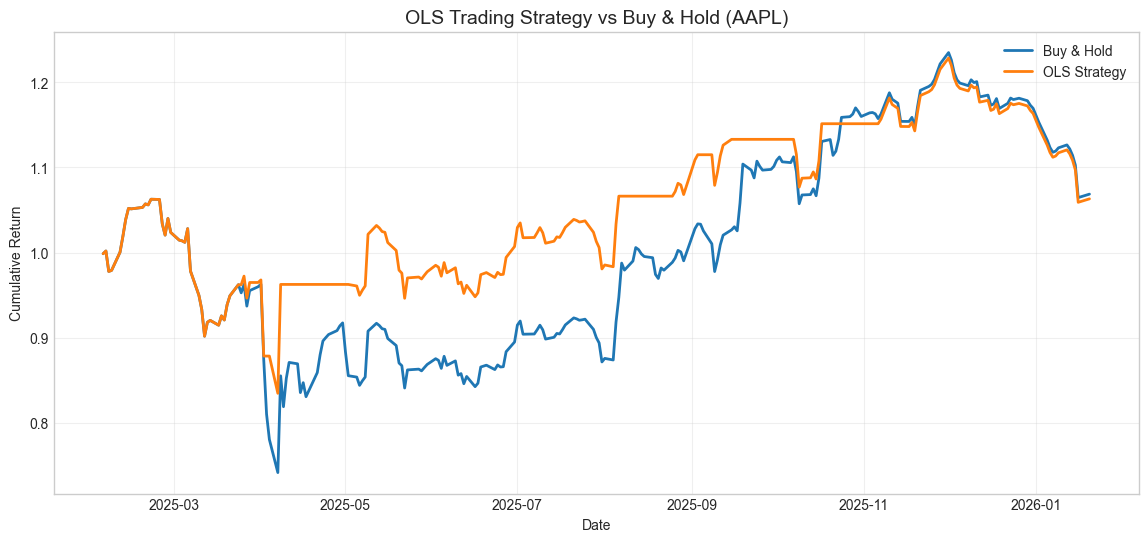

In [7]:
# Trading Strategy based on OLS predictions
backtest = pd.DataFrame(index=y_test.index)
backtest['actual_return'] = y_test.values
backtest['predicted_return'] = y_pred.values

# Signal: Long if predicted return > 0, else cash
backtest['signal'] = np.where(backtest['predicted_return'] > 0, 1, 0)
backtest['strategy_return'] = backtest['signal'] * backtest['actual_return']

# Cumulative returns
backtest['buy_hold_cumulative'] = (1 + backtest['actual_return']).cumprod()
backtest['strategy_cumulative'] = (1 + backtest['strategy_return']).cumprod()

# Plot
plt.figure(figsize=(14, 6))
plt.plot(backtest.index, backtest['buy_hold_cumulative'], label='Buy & Hold', linewidth=2)
plt.plot(backtest.index, backtest['strategy_cumulative'], label='OLS Strategy', linewidth=2)
plt.title(f'OLS Trading Strategy vs Buy & Hold ({target_stock})', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [8]:
# Performance Metrics
def calc_sharpe(returns, rf=RISK_FREE_RATE):
    excess = returns.mean() * TRADING_DAYS - rf
    vol = returns.std() * np.sqrt(TRADING_DAYS)
    return excess / vol if vol > 0 else 0

def max_drawdown(cumulative):
    peak = cumulative.cummax()
    dd = (cumulative - peak) / peak
    return dd.min()

print("\n" + "="*60)
print("STRATEGY PERFORMANCE COMPARISON")
print("="*60)

bh_ret = backtest['buy_hold_cumulative'].iloc[-1] - 1
strat_ret = backtest['strategy_cumulative'].iloc[-1] - 1
bh_sharpe = calc_sharpe(backtest['actual_return'])
strat_sharpe = calc_sharpe(backtest['strategy_return'])
bh_dd = max_drawdown(backtest['buy_hold_cumulative'])
strat_dd = max_drawdown(backtest['strategy_cumulative'])

print(f"\n{'Metric':<25} {'Buy & Hold':>15} {'OLS Strategy':>15}")
print("-" * 55)
print(f"{'Total Return':<25} {bh_ret:>15.2%} {strat_ret:>15.2%}")
print(f"{'Sharpe Ratio':<25} {bh_sharpe:>15.2f} {strat_sharpe:>15.2f}")
print(f"{'Max Drawdown':<25} {bh_dd:>15.2%} {strat_dd:>15.2%}")
print(f"{'Win Rate':<25} {'-':>15} {dir_accuracy:>15.2%}")


STRATEGY PERFORMANCE COMPARISON

Metric                         Buy & Hold    OLS Strategy
-------------------------------------------------------
Total Return                        6.86%           6.31%
Sharpe Ratio                         0.22            0.18
Max Drawdown                      -30.22%         -21.46%
Win Rate                                -          51.04%


In [9]:
# Next Day Prediction
latest_features = X.iloc[[-1]]
latest_features_const = sm.add_constant(latest_features, has_constant='add')
next_day_pred = ols_model.predict(latest_features_const)[0]

print("\n" + "="*60)
print(f"📊 NEXT DAY PREDICTION FOR {target_stock}")
print("="*60)
print(f"\nDate: {df.index[-1].strftime('%Y-%m-%d')}")
print(f"Predicted Return: {next_day_pred:.4%}")
print(f"Signal: {'📈 LONG' if next_day_pred > 0 else '📉 STAY OUT'}")
print(f"\nModel R²: {ols_model.rsquared:.4f}")
print(f"Model Adjusted R²: {ols_model.rsquared_adj:.4f}")


📊 NEXT DAY PREDICTION FOR AAPL

Date: 2026-01-20
Predicted Return: 0.2733%
Signal: 📈 LONG

Model R²: 0.0039
Model Adjusted R²: -0.0044


---

## 🏢 Real-World Applications

| Company | OLS Use Case |
|---------|-------------|
| AQR Capital | Factor model regression for alpha estimation |
| BlackRock | Risk decomposition and attribution |
| Goldman Sachs | Cross-sectional return modeling |
| Citadel | Basis trading and relative value |

### Interview Questions
1. **When does OLS fail in finance?** - Heteroscedasticity, fat tails, autocorrelation
2. **How to fix violations?** - HAC standard errors, GLS, robust regression
3. **R² interpretation?** - Low R² is normal in finance (0.01-0.05 is good!)

---
## 📅 Tomorrow: Ridge Regression (L2 Regularization)